#### Libraries :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.preprocessing import PowerTransformer, Normalizer, OrdinalEncoder, FunctionTransformer
from sklearn import metrics
from scipy import stats
from scipy.stats import norm, skew

from collections import Counter
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

## 1. Load Dataset

In [2]:
df = pd.read_csv('creditcard_2023.csv')
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [3]:
df.shape

(568630, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [5]:
df.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
df['Class'].value_counts()

0    284315
1    284315
Name: Class, dtype: int64

## 2. Feature Selection

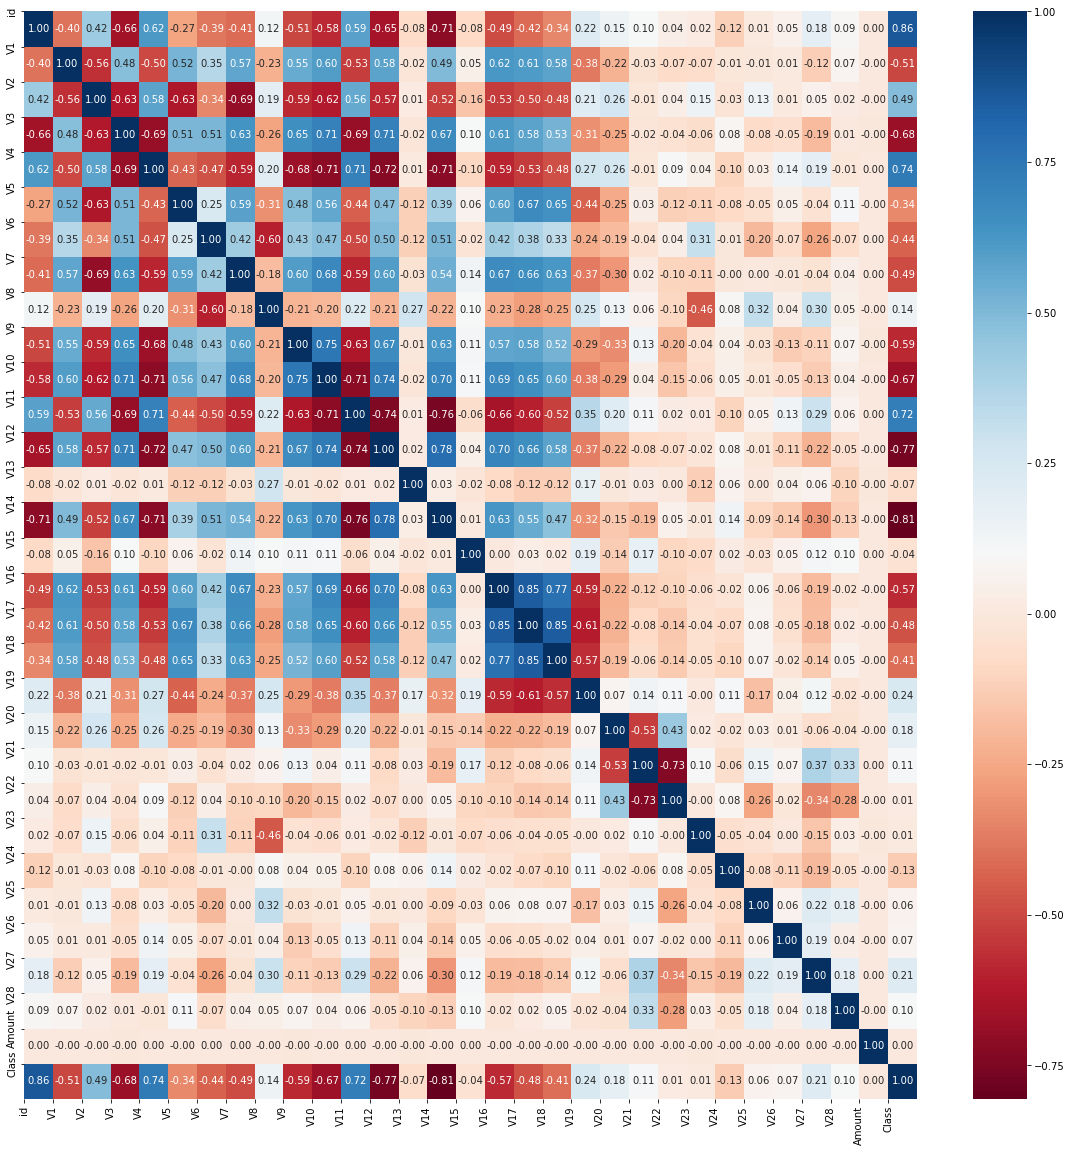

In [7]:
#correlation matrix with heatmap
corr = df.corr(method='pearson')

plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [8]:
#remove unrelated variables
df = df.drop(['Amount','id'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,0


## 3. Train Test Split data

In [9]:
train, test = train_test_split(df, test_size=0.2, random_state=2023)
print(train.shape)
print(test.shape)

(454904, 29)
(113726, 29)


In [10]:
X = train.drop(columns=['Class'], axis=1)
y = train['Class']

## 4. Data Visualization

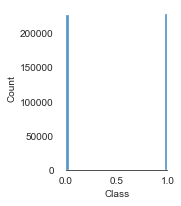

Skewness : -0.0001846549543218345
Kurtosis : -2.0000087590244187


In [11]:
sns.set_style('white')
sns.set_color_codes(palette='deep')

plt.figure(figsize=(2,3))
sns.histplot(train['Class'])
sns.despine(trim=True, left=True)
plt.show()

print("Skewness :", train['Class'].skew())
print("Kurtosis :", train['Class'].kurt())

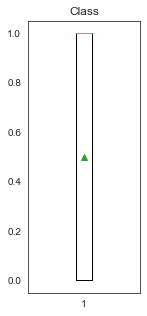

In [12]:
plt.figure(figsize=(2,5))
plt.boxplot(train['Class'], showmeans=True)
plt.title('Class')
plt.show()

In [13]:
print(Counter(y))
print(X.shape)

Counter({1: 227473, 0: 227431})
(454904, 28)


## 5. Feature Engineering

In [14]:
X_train = X
y_train = y

#Standard scaler
standard_scaler = StandardScaler()
x_train_standard_scaler = standard_scaler.fit_transform(X_train)
x_train_standard_scaler = pd.DataFrame(x_train_standard_scaler)

#Robust Scaler
robust_scaler = RobustScaler()
x_train_robust_scaler = robust_scaler.fit_transform(X_train)
x_train_robust_scaler = pd.DataFrame(x_train_robust_scaler)

#MinMax Scaler
minmax_scaler = MinMaxScaler()
x_train_minmax = minmax_scaler.fit_transform(X_train)
x_train_minmax = pd.DataFrame(x_train_minmax)

#MaxAbsscaler
maxabs_scaler = MaxAbsScaler()
x_train_maxabs = maxabs_scaler.fit_transform(X_train)
x_train_maxabs = pd.DataFrame(x_train_maxabs)

#QuantileTransformer
quantile_transformer = QuantileTransformer()
x_train_quantile = quantile_transformer.fit_transform(X_train)
x_train_quantile = pd.DataFrame(x_train_quantile)

#PowerTransfromer
power_transformer = PowerTransformer()
x_train_power = power_transformer.fit_transform(X_train)
x_train_power = pd.DataFrame(x_train_power)

#Normalizer(lb1)
normalizer1 = Normalizer(norm='l1')
x_train_norm1 = normalizer1.fit_transform(X_train)
x_train_norm1 = pd.DataFrame(x_train_norm1)

#Normalizer(lb2)
normalizer2 = Normalizer(norm='l2')
x_train_norm2 = normalizer2.fit_transform(X_train)
x_train_norm2 = pd.DataFrame(x_train_norm2)

#Normalizer(max)
normalizer_max = Normalizer(norm='max')
x_train_norm_max = normalizer_max.fit_transform(X_train)
x_train_norm_max = pd.DataFrame(x_train_norm_max)

#Ordinal Encoder
ordinal_encoder = OrdinalEncoder()
x_train_oe = ordinal_encoder.fit_transform(X_train)
x_train_oe = pd.DataFrame(x_train_oe)

#Function Transformer
function_transformer = FunctionTransformer()
x_train_fun = function_transformer.fit_transform(X_train)
x_train_fun = pd.DataFrame(x_train_fun)


## 6. Modeling

LGBM accuracy with standard scaler : 99.905 %


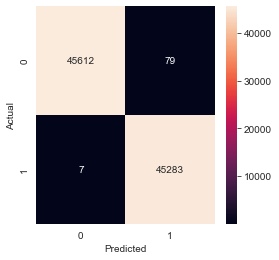

In [15]:
#With Standard scaler
x_train_standard, x_val_standard, y_train_standard, y_val_standard = train_test_split(x_train_standard_scaler, y_train,
                                                                                     test_size=0.2, random_state=2020)
LGBM = LGBMClassifier()
LGBM.fit(x_train_standard, y_train_standard)

y_pred_LGBM_standard = LGBM.predict(x_val_standard)
LGBM_standard_accuracy = accuracy_score(y_val_standard,y_pred_LGBM_standard)
print("LGBM accuracy with standard scaler :", round(LGBM_standard_accuracy*100,3),'%')

cm = confusion_matrix(y_val_standard,y_pred_LGBM_standard)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

LGBM accuracy with robust scaler : 99.901 %


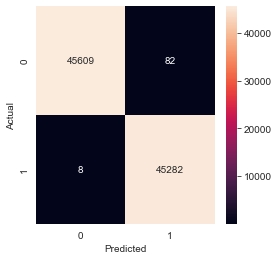

In [16]:
#with robust scaler
x_train_robust, x_val_robust, y_train_robust, y_val_robust = train_test_split(x_train_robust_scaler, y_train, test_size=0.2,
                                                                             random_state=2020)
LGBM = LGBMClassifier()
LGBM.fit(x_train_robust, y_train_robust)
y_pred_LGBM_robust = LGBM.predict(x_val_robust)
LGBM_robust_accuracy = accuracy_score(y_val_robust, y_pred_LGBM_robust)
print("LGBM accuracy with robust scaler :", round(LGBM_robust_accuracy*100,3),'%')

cm = confusion_matrix(y_val_robust, y_pred_LGBM_robust)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy with minmax scaler : 99.909 %


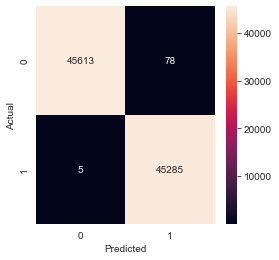

In [17]:
#with minmax_scaler
x_train_minmax_scaler, x_val_minmax_scaler, y_train_minmax_scaler, y_val_minmax_scaler = train_test_split(x_train_minmax,
                                                                                                          y_train,
                                                                                                          test_size=0.2,
                                                                                                          random_state=2020
                                                                                                        )
LGBM = LGBMClassifier()
LGBM.fit(x_train_minmax_scaler, y_train_minmax_scaler)
y_pred_LGBM_minmax = LGBM.predict(x_val_minmax_scaler)
LGBM_accuracy_minmax = accuracy_score(y_val_minmax_scaler,y_pred_LGBM_minmax)
print("LGBM accuracy with minmax scaler :", round(LGBM_accuracy_minmax*100,3),'%')

cm = confusion_matrix(y_val_minmax_scaler, y_pred_LGBM_minmax)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy with maxabs scaler : 99.903 %


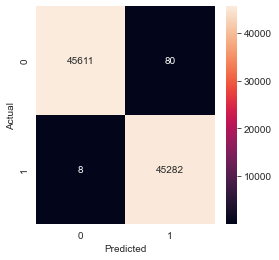

In [18]:
#with maxabs scaler
x_train_maxabs_scaler, x_val_maxabs_scaler, y_train_maxabs_scaler, y_val_maxabs_scaler = train_test_split(x_train_maxabs,
                                                                                                         y_train, test_size=0.2,
                                                                                                         random_state=2020)

LGBM = LGBMClassifier()
LGBM.fit(x_train_maxabs_scaler, y_train_maxabs_scaler)
y_pred_LGBM_maxabs = LGBM.predict(x_val_maxabs_scaler)
LGBM_accuracy_maxabs = accuracy_score(y_val_maxabs_scaler, y_pred_LGBM_maxabs)
print("LGBM accuracy with maxabs scaler :", round(LGBM_accuracy_maxabs*100,3),'%')

cm =confusion_matrix(y_val_maxabs_scaler, y_pred_LGBM_maxabs)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy with quantile transformer : 99.902 %


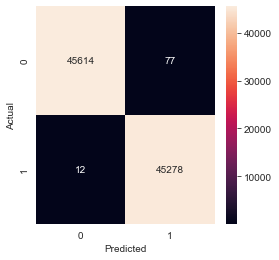

In [19]:
#with quantile transformer

x_train_quantile_trans, x_val_quantile_trans, y_train_quantile_trans, y_val_quantile_trans = train_test_split(x_train_quantile,
                                                                                                             y_train,
                                                                                                             test_size=0.2,
                                                                                                             random_state=2020)

LGBM = LGBMClassifier()
LGBM.fit(x_train_quantile_trans,y_train_quantile_trans)
y_pred_LGBM_quantile = LGBM.predict(x_val_quantile_trans)
LGBM_accuracy_quantile = accuracy_score(y_val_quantile_trans, y_pred_LGBM_quantile)
print("LGBM accuracy with quantile transformer :", round(LGBM_accuracy_quantile*100,3),'%')

cm = confusion_matrix(y_val_quantile_trans, y_pred_LGBM_quantile)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy with power transformer : 99.855 %


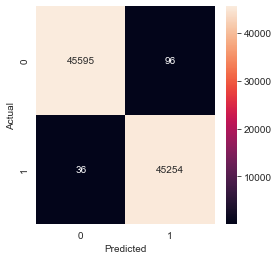

In [20]:
#with power transformer
x_train_power_trans, x_val_power_trans, y_train_power_trans, y_val_power_trans = train_test_split(x_train_power, y_train,
                                                                                                  test_size=0.2,
                                                                                                  random_state=2020)
LGBM = LGBMClassifier()
LGBM.fit(x_train_power_trans, y_train_power_trans)
y_pred_LGBM_power = LGBM.predict(x_val_power_trans)
LGBM_accuracy_power = accuracy_score(y_val_power_trans,y_pred_LGBM_power)
print("LGBM accuracy with power transformer :", round(LGBM_accuracy_power*100,3),'%')

cm = confusion_matrix(y_val_power_trans,y_pred_LGBM_power)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy with Normalizer 1: 99.829 %


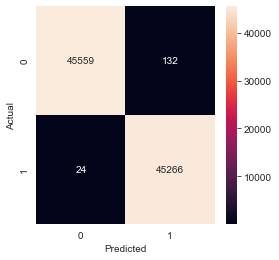

In [21]:
#with normalizer1
x_train_norm1_ , x_val_norm1, y_train_norm1, y_val_norm1 = train_test_split(x_train_norm1, y_train, test_size=0.2,
                                                                           random_state=2020)

LGBM = LGBMClassifier()
LGBM.fit(x_train_norm1_,y_train_norm1)
y_pred_norm1 = LGBM.predict(x_val_norm1)
LGBM_accuracy_norm1= accuracy_score(y_val_norm1,y_pred_norm1)
print("LGBM accuracy with Normalizer 1:", round(LGBM_accuracy_norm1*100,3),'%')

cm = confusion_matrix(y_val_norm1,y_pred_norm1)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy score with normalizer2 : 99.823 %


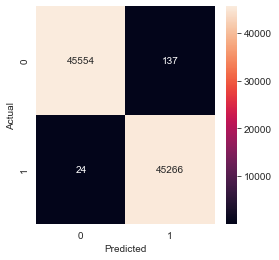

In [22]:
#with normalizer2
x_train_norm2_ , x_val_norm2, y_train_norm2, y_val_norm2 = train_test_split(x_train_norm2, y_train, test_size=0.2,
                                                                           random_state=2020)

LGBM = LGBMClassifier()
LGBM.fit(x_train_norm2_,y_train_norm2)
y_pred_norm2 = LGBM.predict(x_val_norm2)
LGBM_accuracy_norm2 = accuracy_score(y_val_norm2,y_pred_norm2)
print("LGBM accuracy score with normalizer2 :", round(LGBM_accuracy_norm2*100,3),'%')
cm = confusion_matrix(y_val_norm2,y_pred_norm2)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy score with normalizer max : 99.79 %


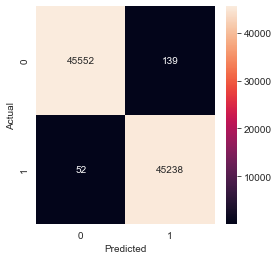

In [23]:
#with normalizer_max
x_train_normmax , x_val_norm_max, y_train_norm_max, y_val_norm_max = train_test_split(x_train_norm_max, y_train, test_size=0.2,
                                                                           random_state=2020)

LGBM = LGBMClassifier()
LGBM.fit(x_train_normmax,y_train_norm_max)
y_pred_norm_max = LGBM.predict(x_val_norm_max)
LGBM_accuracy_norm_max = accuracy_score(y_val_norm_max,y_pred_norm_max)
print("LGBM accuracy score with normalizer max :", round(LGBM_accuracy_norm_max*100,3),'%')
cm = confusion_matrix(y_val_norm_max,y_pred_norm_max)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy score with ordinal encoding : 99.9 %


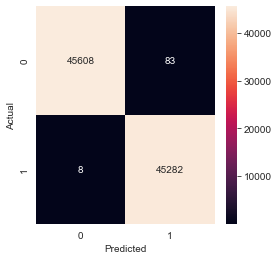

In [24]:
#with ordinal encoding
x_train_oe_, x_val_oe, y_train_oe, y_val_oe = train_test_split(x_train_oe, y_train, test_size= 0.2, random_state=2020)

LGBM = LGBMClassifier()
LGBM.fit(x_train_oe_,y_train_oe)
y_pred_oe = LGBM.predict(x_val_oe)
LGBM_accuracy_oe = accuracy_score(y_val_oe,y_pred_oe)
print("LGBM accuracy score with ordinal encoding :", round(LGBM_accuracy_oe*100,3),'%')
cm = confusion_matrix(y_val_oe,y_pred_oe)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LGBM accuracy score with function transformer : 99.903 %


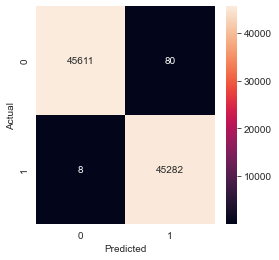

In [25]:
#with function transformer
x_train_fun_, x_val_fun, y_train_fun, y_val_fun = train_test_split(x_train_fun, y_train, test_size=0.2, random_state=2020)

LGBM = LGBMClassifier()
LGBM.fit(x_train_fun_,y_train_fun)
y_pred_fun = LGBM.predict(x_val_fun)
LGBM_accuracy_fun = accuracy_score(y_val_fun,y_pred_fun)
print("LGBM accuracy score with function transformer :", round(LGBM_accuracy_fun*100,3),'%')
cm = confusion_matrix(y_val_fun,y_pred_fun)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7. Accuracy of Validation data

In [26]:
models = [('Standard Scaler', LGBM_standard_accuracy),
         ('Robust Scaler', LGBM_robust_accuracy),
         ('MinMax Scaler', LGBM_accuracy_minmax),
         ('MaxAbs Scaler', LGBM_accuracy_maxabs),
         ('Quantile Transformer', LGBM_accuracy_quantile),
         ('Power Transformer', LGBM_accuracy_power),
         ('Normalizer 1', LGBM_accuracy_norm1),
         ('Normalizer 2', LGBM_accuracy_norm2),
         ('Normalizer max', LGBM_accuracy_norm_max),
         ('Orninal Encoding', LGBM_accuracy_oe),
         ('Function Transformer', LGBM_accuracy_fun)]

accuracy = pd.DataFrame(models, columns=['Preprocessing', 'Accuracy'])
accuracy.sort_values(by=['Accuracy'], ascending=False)

,Preprocessing,Accuracy
2,MinMax Scaler,0.999088
0,Standard Scaler,0.999055
3,MaxAbs Scaler,0.999033
10,Function Transformer,0.999033
4,Quantile Transformer,0.999022
1,Robust Scaler,0.999011
9,Orninal Encoding,0.999000
5,Power Transformer,0.998549
6,Normalizer 1,0.998285
7,Normalizer 2,0.998230


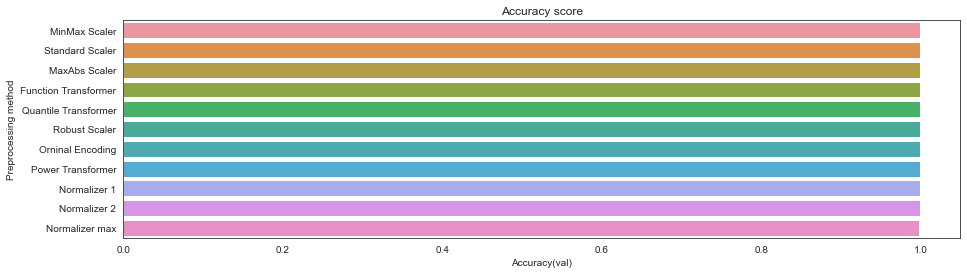

In [27]:
# visualizing model performance

plt.figure(figsize=(15,4))
accuracy.sort_values(by=['Accuracy'], ascending=False)

sns.barplot(x='Accuracy', y='Preprocessing', data=accuracy)
plt.title('Accuracy score')
plt.xlabel('Accuracy(val)')
plt.ylabel('Preprocessing method')
plt.show()

## 8. Test Data

In [28]:
test = test.reset_index(drop=True)
X_test = test.drop('Class',axis=1)
y_test = test['Class']

X_train = X.reset_index(drop=True)
row_no = X_test.shape[0]

print(X_test.shape)
print(y_test.shape)


(113726, 28)
(113726,)


In [29]:
X_test_target = X_train.append(X_test, ignore_index=True)

#Standard Scaler
standardscaler = StandardScaler()
target_standardscaler = standardscaler.fit_transform(X_test_target)
target_standardscaler = pd.DataFrame(target_standardscaler).tail(row_no)

#Robust Scaler 
robustscaler = RobustScaler()
target_robustscaler  = robustscaler.fit_transform(X_test_target)
target_robustscaler = pd.DataFrame(target_robustscaler).tail(row_no)

#MinMax Scaler
minmax_scaler = MinMaxScaler()
target_minmax = minmax_scaler.fit_transform(X_test_target)
target_minmax = pd.DataFrame(target_minmax).tail(row_no)

#Maxabsscaler
maxabs_scaler = MaxAbsScaler()
target_maxabs = maxabs_scaler.fit_transform(X_test_target)
target_maxabs = pd.DataFrame(target_maxabs).tail(row_no)

#QuantileTransformer
quantile_transformer = QuantileTransformer()
target_quantile = quantile_transformer.fit_transform(X_test_target)
target_quantile = pd.DataFrame(target_quantile).tail(row_no)

#PowerTransformer
power_transformer = PowerTransformer()
target_power = power_transformer.fit_transform(X_test_target)
target_power = pd.DataFrame(target_power).tail(row_no)

#Normalizer1
normalizer1 = Normalizer('l1')
target_norm1 = normalizer1.fit_transform(X_test_target)
target_norm1 = pd.DataFrame(target_norm1).tail(row_no)

#Normalizer2
normalizer2 = Normalizer('l2')
target_norm2 = normalizer2.fit_transform(X_test_target)
target_norm2 = pd.DataFrame(target_norm2).tail(row_no)

#Normalizer_max
normalizer_max = Normalizer('max')
target_norm_max = normalizer_max.fit_transform(X_test_target)
target_norm_max = pd.DataFrame(target_norm_max).tail(row_no)

#OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
target_oe = ordinal_encoder.fit_transform(X_test_target)
target_oe = pd.DataFrame(target_oe).tail(row_no)

#Function Transformer
function_trans = FunctionTransformer()
target_fun = function_trans.fit_transform(X_test_target)
target_fun = pd.DataFrame(target_fun).tail(row_no)

In [30]:
#predict test
predict_standard = LGBM.predict(target_standardscaler)
predict_robust = LGBM.predict(target_robustscaler)
predict_minmax = LGBM.predict(target_minmax)
predict_maxabs = LGBM.predict(target_maxabs)
predict_quantile = LGBM.predict(target_quantile)
predict_power = LGBM.predict(target_power)
predict_norm1 = LGBM.predict(target_norm1)
predict_norm2 = LGBM.predict(target_norm2)
predict_norm_max = LGBM.predict(target_norm_max)
predict_oe = LGBM.predict(target_oe)
predict_fun = LGBM.predict(target_fun)

In [31]:
#dataframe
predict_standard_df = pd.DataFrame(predict_standard, columns=['predict_standard'])
predict_robust_df = pd.DataFrame(predict_robust, columns=['predict_robust'])
predict_minmax_df = pd.DataFrame(predict_minmax, columns=['predict_minmax'])
predict_maxabs_df = pd.DataFrame(predict_maxabs, columns=['predict_maxabs'])
predict_quantile_df = pd.DataFrame(predict_quantile, columns=['predict_quantile'])
predict_power_df = pd.DataFrame(predict_power, columns=['predict_power'])
predict_norm1_df = pd.DataFrame(predict_norm1, columns=['predict_norm1'])
predict_norm2_df = pd.DataFrame(predict_norm2, columns=['predict_norm2'])
predict_norm_max_df = pd.DataFrame(predict_norm_max, columns=['predict_norm_max'])
predict_oe_df = pd.DataFrame(predict_oe, columns=['predict_oe'])
predict_fun_df = pd.DataFrame(predict_fun, columns=['predict_fun'])

In [32]:
test_pred = pd.concat([test,predict_standard_df,predict_robust_df,predict_minmax_df,predict_maxabs_df,predict_quantile_df,
                      predict_power_df,predict_norm1_df,predict_norm2_df,predict_norm_max_df,predict_oe_df,predict_fun_df],
                     axis=1)

In [33]:
test_pred

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,predict_robust,predict_minmax,predict_maxabs,predict_quantile,predict_power,predict_norm1,predict_norm2,predict_norm_max,predict_oe,predict_fun
0,-0.995329,1.083655,-1.082905,1.468320,-0.899216,-0.525638,-0.942989,0.831143,-1.387712,-1.059977,...,1,1,1,1,1,1,1,1,0,1
1,-0.346955,-0.928323,0.896495,-3.189137,1.618899,1.924341,0.263046,0.083285,2.597357,-0.197269,...,0,1,1,0,0,1,1,0,0,0
2,-1.754648,1.557163,-1.685425,1.569832,-2.150399,-1.259773,-1.735328,2.320293,-2.208093,-1.957056,...,1,1,1,1,1,1,1,1,0,1
3,-0.464064,0.318215,-0.383832,-0.041236,-0.340200,-0.456211,-0.177529,-0.530617,0.179016,-0.456943,...,1,1,1,1,1,1,1,1,0,1
4,-0.135713,0.090569,-0.104634,-1.386394,0.693447,-0.059673,0.777742,-0.012282,0.037016,0.417547,...,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113721,0.361731,0.160173,-0.292751,0.625265,0.083384,-0.226436,-0.095630,-0.021803,-0.596816,-0.299003,...,1,1,1,0,1,1,1,1,0,1
113722,0.807104,-0.928007,0.916571,-0.896593,-0.218159,0.363247,0.183367,-0.150223,0.236857,0.817998,...,0,1,1,0,0,1,1,0,0,0
113723,-0.792783,0.609971,-1.008196,1.551782,-0.009903,-0.806242,-0.386097,-0.128516,-0.277513,-0.143500,...,1,1,1,1,1,1,1,1,0,1
113724,-0.616859,-0.329391,-0.922524,1.531737,2.266539,-1.954781,-0.125289,-0.037978,-0.974811,-0.357394,...,1,1,1,0,1,1,1,1,0,1


In [34]:
test_pred.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'predict_standard', 'predict_robust', 'predict_minmax',
       'predict_maxabs', 'predict_quantile', 'predict_power', 'predict_norm1',
       'predict_norm2', 'predict_norm_max', 'predict_oe', 'predict_fun'],
      dtype='object')

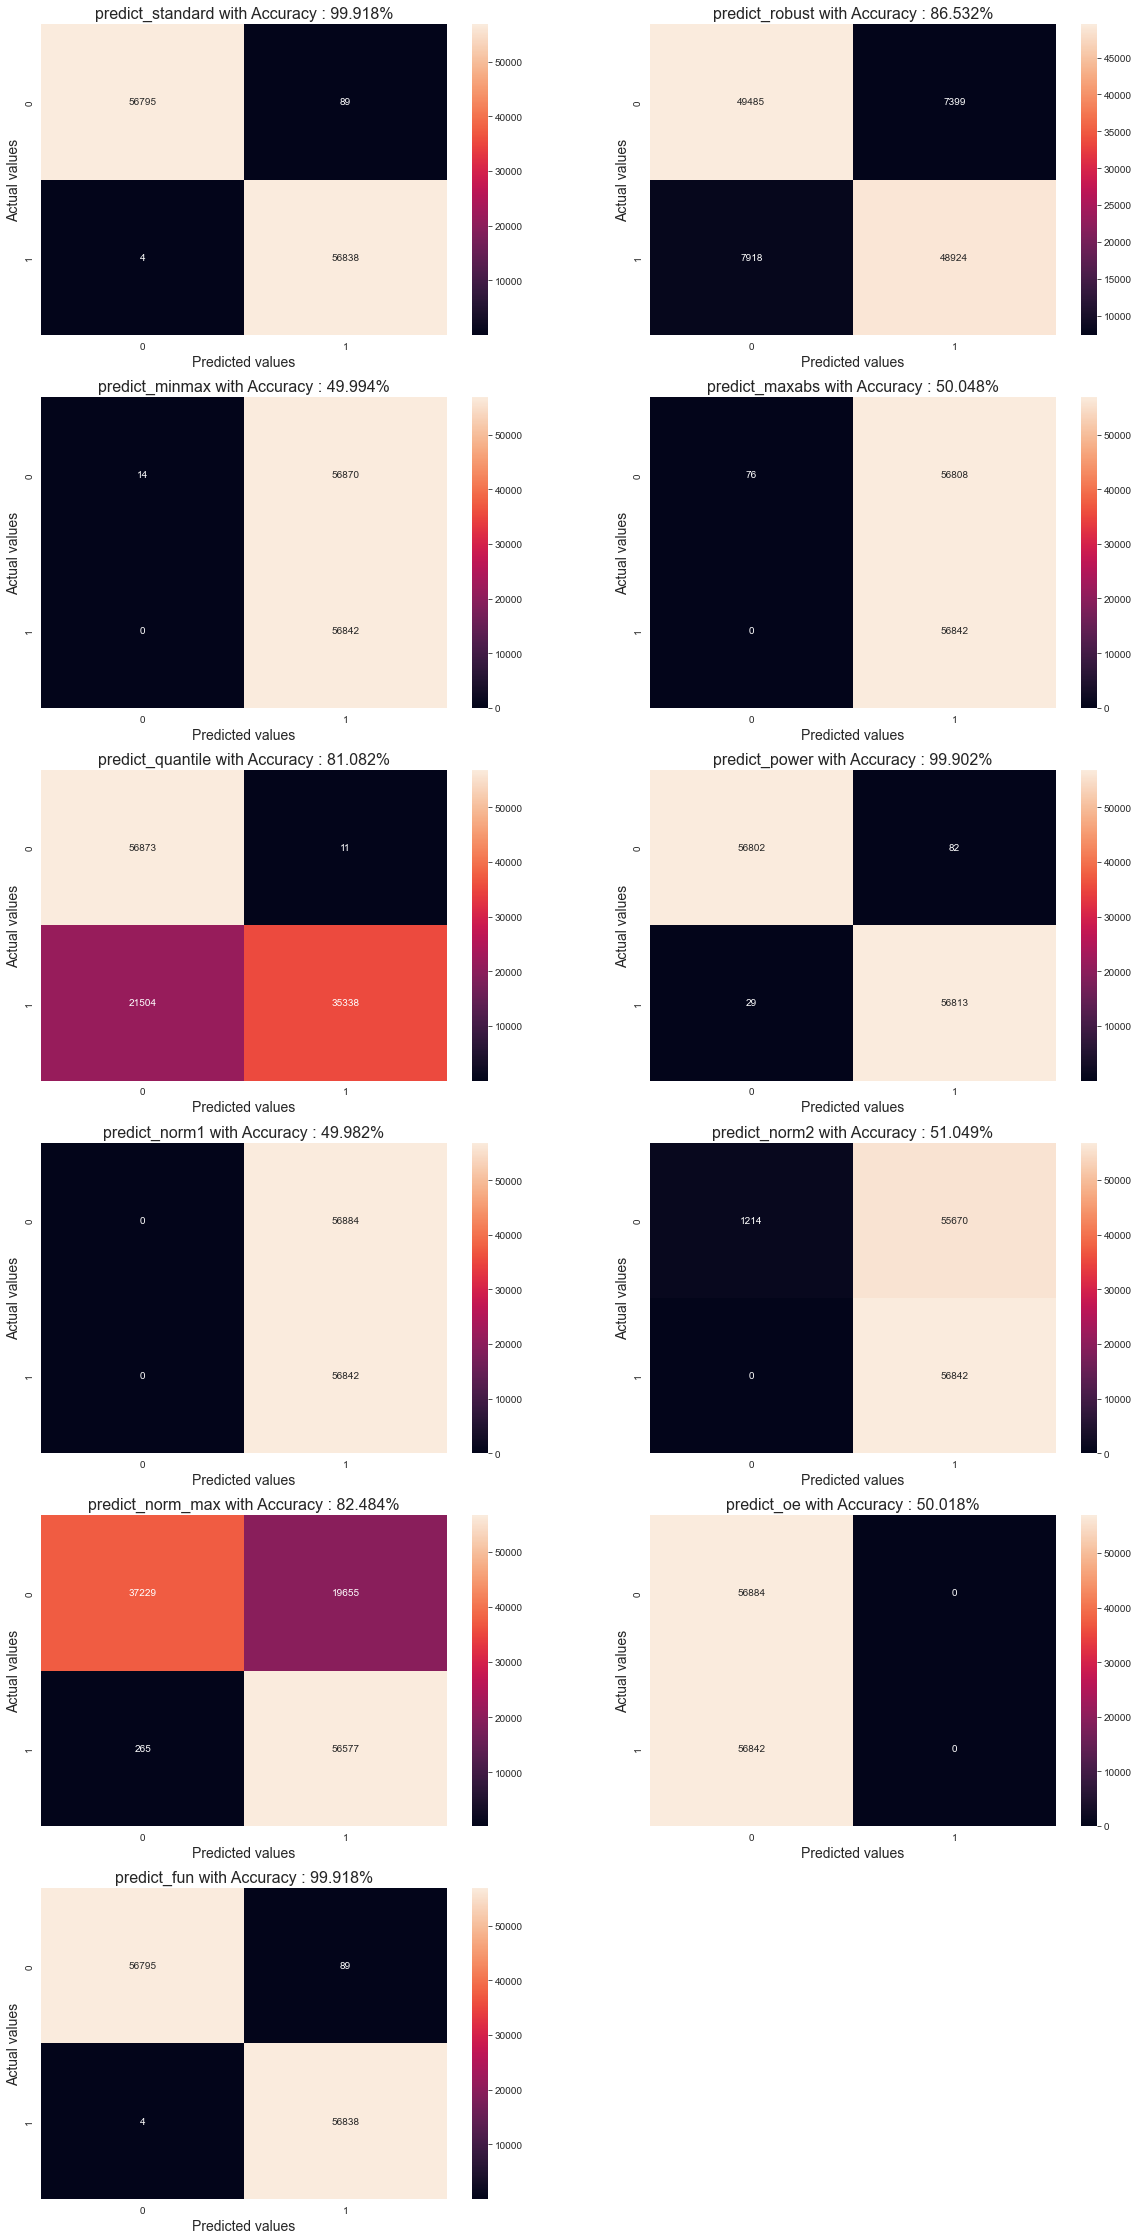

In [39]:
predicted_cols = ['predict_standard', 'predict_robust', 'predict_minmax',
       'predict_maxabs', 'predict_quantile', 'predict_power', 'predict_norm1',
       'predict_norm2', 'predict_norm_max', 'predict_oe', 'predict_fun']

test_accuracy = {}

fig, axes = plt.subplots(6,2, figsize=(20,40))
axes = axes.flatten()

for i, feature in enumerate(predicted_cols):
    acc = accuracy_score(test_pred['Class'],test_pred[feature])
    test_accuracy[feature]=acc
    ax=axes[i]
    cm = confusion_matrix(test_pred['Class'],test_pred[feature])
    sns.heatmap(cm, annot=True, fmt='.0f', ax=ax)
    ax.set_xlabel("Predicted values", fontsize=14)
    ax.set_ylabel("Actual values", fontsize=14)
    ax.set_title(feature + f' with Accuracy : {round(acc*100,3)}%', fontsize=16)
    
if len(predicted_cols) < 12:
    for j in range(len(predicted_cols),12):
        fig.delaxes(axes[j])
        
fig.show()

In [40]:
test_accuracy

{'predict_standard': 0.9991822450451084,
 'predict_robust': 0.8653166382357597,
 'predict_minmax': 0.4999384485517824,
 'predict_maxabs': 0.5004836185217101,
 'predict_quantile': 0.8108172273710497,
 'predict_power': 0.9990239698925487,
 'predict_norm1': 0.4998153456553471,
 'predict_norm2': 0.5104901253890931,
 'predict_norm_max': 0.8248421645006419,
 'predict_oe': 0.500184654344653,
 'predict_fun': 0.9991822450451084}

#### Comapring Accuracy score Test Vs Val

In [ ]:
accuracy